# Utility functions

In [2]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as pulse
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')

qubit = 0

x_sigma = 80
x_duration = 320
f01 = 4924993522.1397295
f12 = 4580649319.495695
x01_amp = 0.08766575883814695
x12_amp = 0.06870562817072146

scale_factor = 1e-7
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
            print('here')
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
            print(i, end='\r')
    return result_data


def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8) - (int(num + 8) % 16)

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def sinusoid(x, A, B, drive_period, phi):
    return A * np.cos(2 * np.pi * x / drive_period - phi) + B

def lorentzian(x, A, q_freq, B, C):
    return (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Mitigation

In [3]:
!pip install cvxopt
from cvxopt import matrix, solvers
def mitigated_population(p, C):
    P = matrix(np.transpose(C).dot(C))
    q = matrix(-np.transpose(p).dot(C))
    G = matrix([[-1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,-1.0]])
    h = matrix([0.0, 0.0, 0.0])
    A = matrix([1.0, 1.0, 1.0], (1,3))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    sol=solvers.qp(P, q, G, h, A, b)
    return sol['x']

def get_population(job_id, discriminator):
    drag_job = backend.retrieve_job(job_id)
    print('getting population from', job_id)
    drag_values = count(drag_job, discriminator)
    return [[val['0']/20000, val['1']/20000, val['2']/20000] for val in drag_values]

def get_mitigated_population(job_id, discriminator, confusion_matrix):
    population = get_population(job_id, discriminator)
    mitigated = [mitigated_population(pop, confusion_matrix) for pop in population]
    return mitigated

  Using cached cvxopt-1.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)


# Gaussian Discriminator

In [6]:
with qisp.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as X01_Gaussian_sched:
    drive_chan = qisp.drive_channel(qubit)
    qisp.set_frequency(f01, drive_chan)
    qisp.play(qisp.Gaussian(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(01)}$'), drive_chan)

with qisp.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as X12_Gaussian_sched:
    drive_chan = qisp.drive_channel(qubit)
    qisp.set_frequency(f12, drive_chan)
    qisp.play(qisp.Gaussian(duration=x_duration,
                            amp=x12_amp,
                            sigma=x_sigma,
                            name=r'$X_{\pi}^{(12)}$'), drive_chan)
    
# Create the three circuits
X01_Gaussian = Gate("$X_{\pi}^{01}$", 1, [])
X12_Gaussian = Gate("$X_{\pi}^{12}$", 1, [])
# 0 state
qc_g = QuantumCircuit(1, 1)
qc_g.measure(0, 0)

# 1 state
qc_e = QuantumCircuit(1, 1)

qc_e.append(X01_Gaussian, [0])
qc_e.add_calibration(X01_Gaussian, (0,), X01_Gaussian_sched, [])
qc_e.measure(0, 0)

# 2 state 
qc_f = QuantumCircuit(1, 1)
qc_f.append(X01_Gaussian, [0])
qc_f.append(X12_Gaussian, [0])
qc_f.measure(0, 0)
qc_f.add_calibration(X01_Gaussian, (0,), X01_Gaussian_sched, [])
qc_f.add_calibration(X12_Gaussian, (0,), X12_Gaussian_sched, [])

# Assemble the schedules into a program\
NUM_SHOTS = 20000
IQ_012_job = backend.run([qc_g, qc_e, qc_f], 
                          meas_level=1, 
                          meas_return='single', 
                          shots=NUM_SHOTS)
IQ_012_job.job_id()

(60000, 2)
60000
retrieving data from 6364c464718d11b10862f44c
data is retrieved from 6364c464718d11b10862f44c


[[0.9778, 0.0089, 0.0133],
 [0.0108, 0.97865, 0.01055],
 [0.0079, 0.03235, 0.95975]]

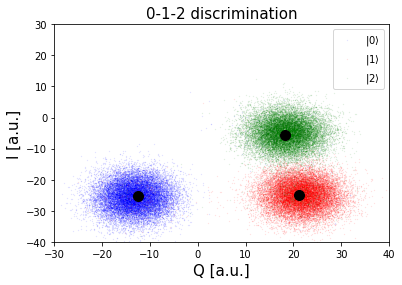

In [4]:
IQ_012_job = backend.retrieve_job('6364c464718d11b10862f44c')

IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped


# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)
two_data_reshaped = reshape_complex_vec(two_data)

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape)  # verify IQ data shape

NUM_SHOTS = 20000

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)


def count(job, discriminator):
    print('retrieving data from', job.job_id())
    data = get_job_data(job, average=False)
    print('data is retrieved from', job.job_id())
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    alpha = 0.2
    size = 0.05
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')
    
x_min = -30
x_max = 40
y_min = -40
y_max = 30
IQ_012_plot(x_min, x_max, y_min, y_max)

discr_data = count(IQ_012_job, LDA_012)
#confusion matrix
conf_mat = [[discr_data[i]['0'] / 20000, discr_data[i]['1'] / 20000, discr_data[i]['2'] / 20000] for i in
                   range(np.shape(discr_data)[0])] 
conf_mat

# DRAG 01 calibration

## $\beta^{(01)}$ sweeping - XX experiment

In [40]:
drive_betas = np.linspace(-25, 25, 100)
def exp_drag_circs(n, drive_betas):
    drive_beta = Parameter('drive_beta')
    with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
        qisp.set_frequency(f01, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                            amp=x01_amp,
                            sigma=x_sigma,
                            beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))

    XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
    qc_DRAG = QuantumCircuit(1, 1)
    qc_DRAG.x(0)
    i = 0
    while i < n:
        qc_DRAG.append(XX, [0])
        i += 1
    qc_DRAG.measure(0, 0)
    qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
    return [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [14]:
drag01_sweeping_job = []
drag01_sweeping_job_id = []
for i in range(5):
    drag_job = backend.run(exp_drag_circs(2*i + 3, drive_betas),
                           meas_level=1,
                           meas_return='single',
                           shots=20000)
    drag01_sweeping_job.append(drag_job)
    drag01_sweeping_job_id.append(drag_job.job_id())
drag_sweeping_job_id

['6364c7a03f146d29e7ee7378',
 '6364c7a3c1827887e276b866',
 '6364c7a5ad2414c0d610eb1f',
 '6364c7a7d0f9b2d81b6512b0',
 '6364c7aae0f73014dd9bd132']

In [ ]:
drag_sweeping

In [37]:
job_ids = ['6364c7a03f146d29e7ee7378',
         '6364c7a3c1827887e276b866',
         '6364c7a5ad2414c0d610eb1f',
         '6364c7a7d0f9b2d81b6512b0',
         '6364c7aae0f73014dd9bd132']
population = [get_mitigated_population(id, LDA_012, conf_mat) for id in job_ids]

getting population from 6364c7a03f146d29e7ee7378
retrieving data from 6364c7a03f146d29e7ee7378
data is retrieved from 6364c7a03f146d29e7ee7378
getting population from 6364c7a3c1827887e276b866
retrieving data from 6364c7a3c1827887e276b866
data is retrieved from 6364c7a3c1827887e276b866
getting population from 6364c7a5ad2414c0d610eb1f
retrieving data from 6364c7a5ad2414c0d610eb1f
data is retrieved from 6364c7a5ad2414c0d610eb1f
getting population from 6364c7a7d0f9b2d81b6512b0
retrieving data from 6364c7a7d0f9b2d81b6512b0
data is retrieved from 6364c7a7d0f9b2d81b6512b0
getting population from 6364c7aae0f73014dd9bd132
retrieving data from 6364c7aae0f73014dd9bd132
data is retrieved from 6364c7aae0f73014dd9bd132


Job id:
02/11/22: ['6364c7a03f146d29e7ee7378',
         '6364c7a3c1827887e276b866',
         '6364c7a5ad2414c0d610eb1f',
         '6364c7a7d0f9b2d81b6512b0',
         '6364c7aae0f73014dd9bd132']

Text(0, 0.5, '$P_{|1\\rangle}$')

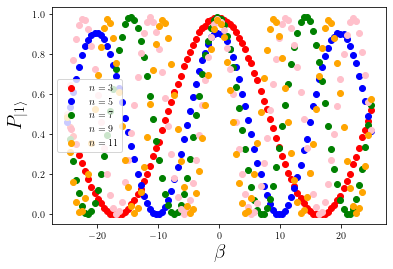

In [41]:
colors = ['red', 'blue', 'green', 'pink', 'orange']
plt.rcParams['text.usetex'] = True
for i in range(5):
    plt.scatter(drive_betas, [pop[1] for pop in population[i]], marker='o', linestyle='-', color= colors[i])
    
plt.legend([f'$n = {2*i + 3}$' for i in range(5)], fontsize = 10)
plt.xlabel('$\\beta$', fontsize = 20)
plt.ylabel('$P_{|1\\rangle}$', fontsize = 20)

In [42]:
params = []
periods = [40, 20, 20, 20, 10]
for i in range(5):
    param = curve_fit(sinusoid, drive_betas, [exp[1] for exp in population[i]], [1, 0.5, periods[i], 0])[0]
    params.append(param)

In [43]:
beta_optimum = 0
max_val = 1
for x in x_val:
    l = 0
    for i in range(3):
        l += (sinusoid(x, *params[i]) + np.abs(params[i][0]) - params[i][1])**2 
    if l > max_val:
        max_val = l
        beta_optimum = x
beta_optimum

-0.17001700170015965

In [ ]:
x_val = np.linspace(-25, 25, 1000)
legends = []
for i in range(2):
    plt.scatter(drive_betas, [exp[1] for exp in population[i]], marker='o', linestyle='-', color= colors[i])
    plt.xlabel('$\\beta$', fontsize = 20)
    plt.ylabel('$P_{|1\\rangle}$', fontsize = 20)
    plt.plot(x_val, [sinusoid(x, *params[i]) for x in x_val], color=colors[i])
    legends.append(f'$n = {2*i + 3}$')
    legends.append(f'$n = {2*i + 3}$')
plt.axvline(x=beta_optimum, color='m', linestyle='dashed')     
plt.legend(legends, fontsize = 10, loc='upper right')
plt.xlabel('$\\beta$', fontsize = 20)
plt.ylabel('$P_{|1\\rangle}$', fontsize = 20)

## $\beta^{(01)}$ sweeping - Single gate experiment

In [12]:
drive_betas = np.linspace(-100, 100, 100)
drive_beta = Parameter('drive_beta')
with qisp.build(backend=backend, default_alignment='sequential') as X01_drag_sched:
    qisp.set_frequency(f01, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x01_amp,
                        sigma=x_sigma,
                        beta=drive_beta), qisp.drive_channel(0))

In [25]:
qc_X = QuantumCircuit(1, 1)
X01_drag = Gate("$X^{01}_\pi$", 1, [drive_beta])
qc_X.add_calibration(X01_drag, (0,), X01_drag_sched, [drive_beta])
qc_X.append(X01_drag, [0])
qc_X.measure(0, 0)
X01_drag_circs = [qc_X.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]


In [26]:
X01_drag_job = backend.run(X01_drag_circs,
                              meas_level=1,
                              meas_return='single',
                              shots=20000)
X01_drag_job.job_id()

'6365294ead241435f510eca5'

In [13]:
population = get_mitigated_population('6365294ead241435f510eca5', LDA_012, conf_mat)

getting population from 6365294ead241435f510eca5
retrieving data from 6365294ead241435f510eca5
data is retrieved from 6365294ead241435f510eca5


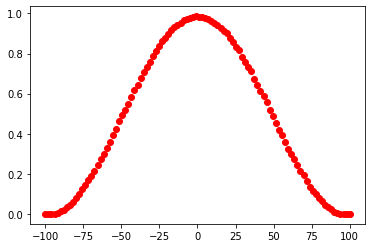

In [21]:
plt.scatter(drive_betas, [pop[1] for pop in population], marker='o', linestyle='-', color= 'red')


[ 4.95787518e-01  4.91056018e-01  1.97012995e+02 -1.05989621e-03]
optimal value for beta is  0.03323367317169175


0.986774230345822

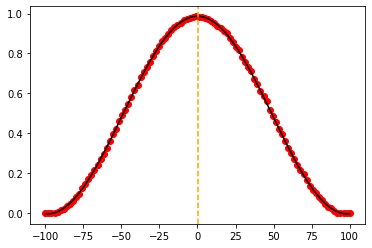

In [32]:
params = curve_fit(sinusoid, drive_betas, [pop[1] for pop in population], [0.5, 0.5, 100, 0], maxfev = 50000)[0]
print(params)

x_val = np.linspace(drive_betas[0], drive_betas[-1], 10000)
plt.scatter(drive_betas, [pop[1] for pop in population], marker='o', linestyle='-', color= 'red')
plt.plot(x_val, sinusoid(x_val, *params), color= 'black')
beta_opt = -params[-1]*params[-2]/(2*np.pi)
plt.axvline(x = beta_opt, color='orange', linestyle='dashed')
print('optimal value for beta is', beta_opt)
sinusoid(params[1], *params)

Job id:
09/11/22: '6365294ead241435f510eca5'


## Testing $\beta$

In [28]:
with qisp.build(backend=backend, default_alignment='sequential') as X01_drag_sched:
    qisp.set_frequency(f01, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x01_amp,
                        sigma=x_sigma,
                        beta=beta_optimum), qisp.drive_channel(0))

In [36]:
testing_beta_circs = []
for i in range(100):
    qc_X = QuantumCircuit(1, 1)
    X01_drag = Gate("$X^{01}_\pi$", 1, [])
    qc_X.add_calibration(X01_drag, (0,), X01_drag_sched, [])
    qc_X.append(X01_drag, [0])
    qc_X.measure(0, 0)
    testing_beta_circs.append(qc_X)


In [37]:
len(testing_beta_circs)

100

In [38]:
NUM_SHOTS = 20000
testing_beta_job = backend.run(testing_beta_circs, 
                          meas_level=1, 
                          meas_return='single', 
                          shots=NUM_SHOTS)
testing_beta_job.job_id()

'63652a30718d1161b362f5ef'

In [34]:
population = get_mitigated_population('63652a30718d1161b362f5ef', LDA_012, conf_mat)

getting population from 63652a30718d1161b362f5ef
retrieving data from 63652a30718d1161b362f5ef
data is retrieved from 63652a30718d1161b362f5ef


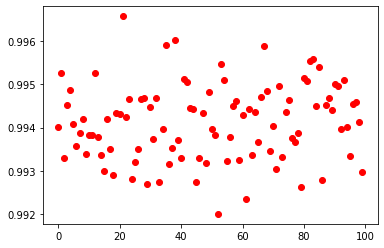

In [36]:
plt.scatter(range(100), [pop[1] for pop in population], marker='o', linestyle='-', color= 'red')

## Overrotation correction

In [5]:
def overrot_circs(x01_amp):
    with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as X01_Gaussian_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f01, drive_chan)
        pulse.play(pulse.Gaussian(duration=x_duration,
                                amp=x01_amp,
                                sigma=x_sigma,
                                name=r'$X_{\pi}^{(01)}$'), drive_chan)
    
    re_circs = []
    for i in range(100):
        qc_re = QuantumCircuit(1, 1)
        X01_Gaussian = Gate("$X_\pi^{01}$", 1, [])
        qc_re.add_calibration(X01_Gaussian, (0,), X01_Gaussian_sched, [])
        qc_re.append(X01_Gaussian, [0])
        for j in range(i):
            qc_re.append(X01_Gaussian, [0])
        qc_re.measure(qubit, 0)
        re_circs.append(qc_re)
    return re_circs

In [11]:
x01_amp = 0.08660095392689886

In [46]:
re_job = backend.run(overrot_circs(x01_amp),
                    meas_level=1,
                    meas_return='single',
                    shots=20000)
re_job.job_id()

'636d24bcd0f9b27e35652ce3'

job id
10/11/22 
'636bc76b0565be42460071ab' eps = 0.01913357328410272 corrected amp = 0.08713507091997975
'636d1ec5ad241468611105d3' eps = 0.019375976193482317 corrected amp = 0.08660095392689886
'636d24bcd0f9b27e35652ce3' eps = 0.013847231440615022 corrected amp = 0.08622091707127921

In [6]:
population = get_mitigated_population('636d24bcd0f9b27e35652ce3', LDA_012, conf_mat)

getting population from 636d24bcd0f9b27e35652ce3
retrieving data from 636d24bcd0f9b27e35652ce3
data is retrieved from 636d24bcd0f9b27e35652ce3


(0.0, 1.0)

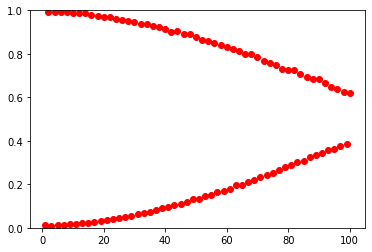

In [7]:
zero_population = [pop[0] for pop in population]
plt.scatter(range(1, 101), zero_population, marker='o', linestyle='-', color= 'red')
plt.ylim(0, 1)

epsilon = 0.013847231440615022
r-squared = 0.998942098526973


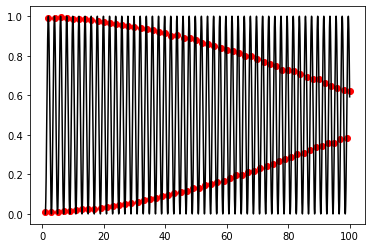

In [8]:
from sklearn.metrics import r2_score

def population_theory(n, eps):
    return 1/2*np.cos(n*(np.pi + eps)) + 1/2
params = curve_fit(population_theory, range(1, 101), zero_population, [0], maxfev = 50000)[0]
eps = params[0]
print('epsilon =', eps)
m = 100
x_val = np.linspace(1, m, 10000)
plt.scatter(range(1, m + 1), zero_population[0:m], marker='o', linestyle='-', color= 'red')
plt.plot(x_val, population_theory(x_val, *params), color= 'black')

zero_population_theory = population_theory(range(1,101), *params)
print('r-squared =', r2_score(zero_population, zero_population_theory))

In [13]:
x01_amp_corrected = np.pi/(np.pi + eps)*x01_amp
print('epsilon =', eps)
print('amp =', x01_amp)
print('corrected amp =', x01_amp_corrected)
print('x01_amp is corrected by ' +  str(np.abs((x01_amp_corrected - x01_amp))/x01_amp*100) + ' percent')


epsilon = 0.013847231440615022
amp = 0.08660095392689886
corrected amp = 0.08622091707127921
x01_amp is corrected by 0.43883680073598214 percent


getting population from 636d225ce0f730ba319beb4f
retrieving data from 636d225ce0f730ba319beb4f
data is retrieved from 636d225ce0f730ba319beb4f


epsilon = 0.023251763637231738
r-squared = 0.11255632441886931


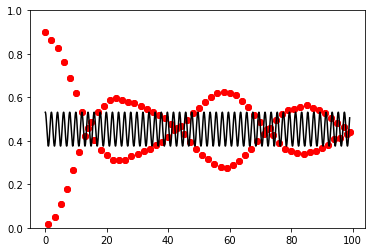

In [60]:
from sklearn.metrics import r2_score

zero_population = [pop[1] for pop in population]
plt.scatter(range(100), zero_population, marker='o', linestyle='-', color= 'red')
plt.ylim(0, 1)

def population_theory(n, A, B, eps):
    return A*np.cos(n*(np.pi + eps)) + B

params = curve_fit(population_theory, range(100), zero_population, [0.45, 0.45, 0.01], maxfev = 50000)[0]
eps = params[2]
print('epsilon =', eps)
m = 100
x_val = np.linspace(0, m - 1, 10000)
plt.scatter(range(0, m), zero_population[0:m], marker='o', linestyle='-', color= 'red')
plt.plot(x_val, population_theory(x_val, *params), color= 'black')

zero_population_theory = population_theory(range(100), *params)
print('r-squared =', r2_score(zero_population, zero_population_theory))